In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


1-Carregar o Dataset limpo

In [2]:
df = pd.read_csv("../data/students_clean.csv")
df = df.dropna()
df.head()


,student_id,age,gender,parental_education,study_hours_week,attendance_rate,extracurricular,sleep_hours,previous_scores,tutoring,internet_quality,family_income,health_status,final_grade,study_efficiency,sleep_quality
0,STD01416,0.175417,5,8,-0.974905,1.029991,5,-0.428905,-0.869233,3,6,0.808160,6,-0.903313,-0.013391,-0.428905
1,STD01345,-1.128525,5,8,0.715019,-0.084645,5,0.980578,-0.772277,3,6,0.808160,6,0.853169,-0.041061,0.980578
2,STD01705,1.479359,5,11,0.080192,0.008848,5,-0.333786,1.580030,3,6,0.808160,6,1.064648,0.250610,-0.333786
3,STD00299,-0.259230,3,8,-1.364208,0.903257,5,0.003452,-0.701762,5,8,-0.472043,4,-0.706652,-0.018684,0.003452
4,STD01762,-1.128525,3,8,-1.289001,-0.955162,5,0.928696,-0.363515,3,8,0.808160,4,-1.191570,-0.021946,0.928696


1.1-Separar features e target

Como estamos prevendo students_performance, essa coluna se torna o alvo (y), enquanto todas as demais colunas passam a ser os atributos (X) utilizados para treinar o modelo.

In [3]:
df_model = df.drop(columns=["student_id"])   # removendo ID

X = df_model.drop(columns=["study_hours_week"])
y = df_model["study_hours_week"]


1.2-Divisão dos dados (60/20/20)

Primeiro separamos teste (20%).
Depois dividimos o restante em treino (60%) e validação (20%).

In [4]:
# 1º split: treino (60%) e restante (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42
)

# 2º split: validação (20%) e teste (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

1.3-Criando e treinando o modelo Baseline

In [5]:
# identificar colunas
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

# pipeline de transformação
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# transformar
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)
X_test_t = preprocess.transform(X_test)

# modelo baseline
model = LinearRegression()
model.fit(X_train_t, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


1.4-Avaliação do modelo (treino e validação)

Calculamos todas as métricas obrigatórias (MSE, RMSE, MAE, R²) para comparar treino vs validação e identificar possíveis sinais de overfitting.

In [6]:
# predições
train_pred = model.predict(X_train_t)
val_pred = model.predict(X_val_t)

# métricas
def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_train, r2_train = calc_metrics(y_train, train_pred)
rmse_val, r2_val = calc_metrics(y_val, val_pred)

print("TREINO → RMSE:", rmse_train, " | R²:", r2_train)
print("VALIDAÇÃO → RMSE:", rmse_val, " | R²:", r2_val)


TREINO → RMSE: 0.6964965271843735  | R²: 0.4914899855221494
VALIDAÇÃO → RMSE: 0.7286379608578134  | R²: 0.48442604132104605


1.5-Gráfico: Predições vs Valores Reais

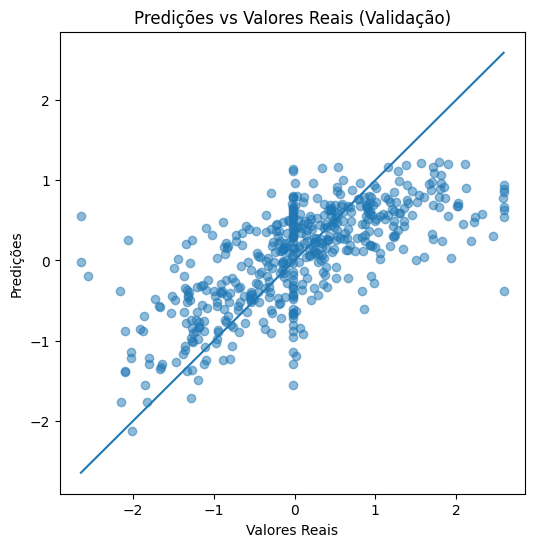

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_pred, alpha=0.5)
plt.xlabel("Valores Reais")
plt.ylabel("Predições")
plt.title("Predições vs Valores Reais (Validação)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
plt.show()

Pense neste gráfico como um "teste de acerto" do seu modelo.

O eixo X é a resposta correta (o valor real que deveria ser previsto).

O eixo Y é a resposta do modelo (o valor que ele previu).

Se o modelo acerta perfeitamente, a resposta dele (Y) é igual à resposta correta (X), formando uma linha diagonal. Se a nuvem de pontos estiver muito "gorda" ou espalhada longe dessa linha, significa que o modelo erra com frequência e por grandes margens.

Ele ajuda a ver se o modelo tem uma "mania" de errar para um lado específico (sempre chutar para mais ou sempre chutar para menos).

1.6-Distribuição dos resíduos

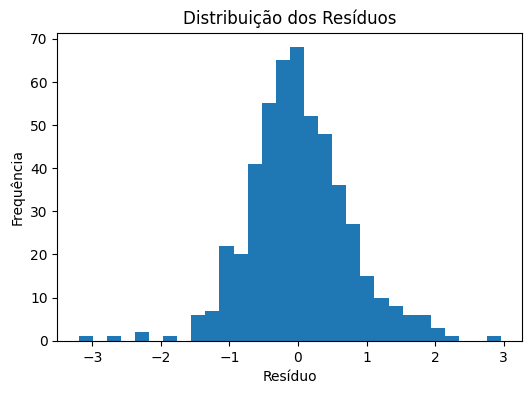

In [8]:
residuals = y_val - val_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.show()


Os erros devem estar distribuídos simetricamente em torno do zero. Isso significa que o modelo erra para mais ou para menos com a mesma frequência, sem uma tendência forte para um lado.

1.7-Importância das Features

Coeficientes positivos contribuem para o aumento da students_performance, enquanto coeficientes negativos indicam redução.
O gráfico apresenta os 10 atributos mais relevantes do modelo de regressão.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# -----------------------------
# 1. SEPARAR FEATURES E TARGET
# -----------------------------
X = df.drop("final_grade", axis=1)
y = df["final_grade"]

# -----------------------------
# 2. IDENTIFICAR TIPOS DE COLUNAS
# -----------------------------
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# -----------------------------
# 3. TRANSFORMER (OneHot + numéricos)
# -----------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# -----------------------------
# 4. PIPELINE COMPLETO
# -----------------------------
pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

# -----------------------------
# 5. TREINAR (CORRIGIDO)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

print("Treinamento concluído!")


Treinamento concluído!


In [10]:
# 1. Pegar o OneHotEncoder já treinado dentro do pipeline
ohe = pipeline.named_steps["preprocess"].named_transformers_["cat"]

# 2. Nomes das colunas One-Hot
ohe_features = ohe.get_feature_names_out(categorical_cols).tolist()

# 3. Juntar com as colunas numéricas (sem .tolist(), pois já é lista)
feature_names = ohe_features + numeric_cols

# 4. Coeficientes do modelo linear
coef_df = pd.DataFrame({
    "feature": feature_names,
    "importance": pipeline.named_steps["model"].coef_
}).sort_values(by="importance", ascending=False)

coef_df.head(20)


,feature,importance
1384,student_id_STD01746,1.835416
1855,student_id_STD02328,1.749277
174,student_id_STD00228,1.695562
1745,student_id_STD02187,1.644760
1878,student_id_STD02356,1.638078
1543,student_id_STD01935,1.622529
1960,student_id_STD02455,1.526939
941,student_id_STD01182,1.489314
512,student_id_STD00652,1.459257
81,student_id_STD00117,1.449690


1.8-Salvar Modelo

In [11]:
with open("modelo_views.pkl", "wb") as f:
    pickle.dump({
        "preprocess": preprocess,
        "model": model
    }, f)

print("Modelo salvo como modelo_views.pkl")


Modelo salvo como modelo_views.pkl
